In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import START, END
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from operator import add
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Markdown, Image, display
from dotenv import dotenv_values
from pypdf import PdfReader
import pandas as pd
import os

In [2]:
env_values = {**dotenv_values(".env.shared"), **dotenv_values(".env.secret")}

os.environ["LANGSMITH_TRACING"] = env_values["LANGSMITH_TRACING"]
os.environ["LANGSMITH_ENDPOINT"] = env_values["LANGSMITH_ENDPOINT"]
os.environ["LANGSMITH_API_KEY"] = env_values["LANGSMITH_API_KEY"]
os.environ["LANGSMITH_PROJECT"] = env_values["LANGSMITH_PROJECT"]
os.environ["OPENAI_API_KEY"] = env_values["OPENAI_API_KEY"]

## Summarization graph

In [59]:
PATH_TO_FILES = "./Data"

In [60]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

def read_docs():
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return text

In [46]:
test = read_docs()

EmptyDataError: No columns to parse from file

In [6]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.4, top_p=0.38)

In [7]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Ignore any IDs"),
    ("human", "Summarize this {input}")
])

In [8]:
runnable_summarization = summarization_prompt | llm

In [9]:
output = runnable_summarization.invoke({'input': test}).content

In [10]:
Markdown(output)

**Employee Profiles:**

1. **Alice Doe** - Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. **Bob Smith** - Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. **Carol Lee** - Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. **David Wong** - Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. **Eva Patel** - Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

**Travel Requests:**

1. **Alice Doe** - Berlin for a Conference from 2024-07-15 to 2024-07-20, Budget: $2500, Status: Approved
2. **Bob Smith** - London for a Client Meeting from 2024-08-01 to 2024-08-05, Budget: $3000, Status: Pending
3. **Carol Lee** - Tokyo for Research from 2024-09-10 to 2024-09-20, Budget: $4500, Status: Approved
4. **David Wong** - Toronto for Internal Audit from 2024-10-05 to 2024-10-15, Budget: $3500, Status: Rejected
5. **Eva Patel** - Dubai for a Business Expo from 2024-11-01 to 2024-11-10, Budget: $2000, Status: Approved

**Organizational Rules:**

1. Max budget per trip per employee is $3,000, region dependent.
2. Business class flights are only for Director level & above.
3. Approval from direct manager is required for travel abroad.
4. Preferred airline partners are Lufthansa, Emirates, and Delta.
5. Hotels must be 4-star or higher for company bookings.
6. Travel insurance is mandatory for international trips.
7. Employees cannot book flights exceeding the budget limit.
8. Visa approval must be completed before flight booking.

### Creation of the summary graph

In [11]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.4, top_p=0.38)

#### States

In [12]:
class SummaryGraphInput(TypedDict):
    summary: str
    text: str

class SummaryGraphOutput(TypedDict):
    summary: str


#### Utils

In [13]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

#### Prompts

In [14]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Ignore any IDs. Do not provide the output in any font or styles. Provide the summary in a neat structured format."),
    ("human", "Summarize this {input}")
])

#### Nodes

In [15]:
def read_docs(state: SummaryGraphInput):
    PATH_TO_FILES = "./Data"
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return {'text': text}

In [16]:
def summarize(state: SummaryGraphInput):
    text = state['text']
    runnable_summarization = summarization_prompt | llm
    output = runnable_summarization.invoke({'input': text}).content
    with open("./summary/summary.txt", "w") as f:
        f.write(output)
    return {'summary': output}

In [17]:
graph_summarizer_builder = StateGraph(SummaryGraphInput, output=SummaryGraphOutput)

graph_summarizer_builder.add_node("read documents", read_docs)
graph_summarizer_builder.add_node("summarize documents", summarize)

graph_summarizer_builder.add_edge(START, "read documents")
graph_summarizer_builder.add_edge("read documents", "summarize documents")
graph_summarizer_builder.add_edge("summarize documents", END)

memory = MemorySaver()
graph_summarizer = graph_summarizer_builder.compile()

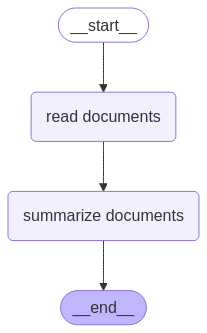

In [9]:
display(Image(graph_summarizer.get_graph().draw_mermaid_png()))

In [18]:
Markdown(graph_summarizer.invoke({}, config={'configurable': {'thread_id': "summarizer_3"}})['summary'])

**Employee Profiles:**

1. **Alice Doe**
   - Role: Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. **Bob Smith**
   - Role: Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. **Carol Lee**
   - Role: Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. **David Wong**
   - Role: Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. **Eva Patel**
   - Role: Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

**Travel Requests:**

1. **TR001**
   - Employee: Alice Doe
   - Destination: Berlin
   - Purpose: Conference
   - Dates: 2024-07-15 to 2024-07-20
   - Budget Limit: $2500
   - Approval Status: Approved

2. **TR002**
   - Employee: Bob Smith
   - Destination: London
   - Purpose: Client Meeting
   - Dates: 2024-08-01 to 2024-08-05
   - Budget Limit: $3000
   - Approval Status: Pending

3. **TR003**
   - Employee: Carol Lee
   - Destination: Tokyo
   - Purpose: Research
   - Dates: 2024-09-10 to 2024-09-20
   - Budget Limit: $4500
   - Approval Status: Approved

4. **TR004**
   - Employee: David Wong
   - Destination: Toronto
   - Purpose: Internal Audit
   - Dates: 2024-10-05 to 2024-10-15
   - Budget Limit: $3500
   - Approval Status: Rejected

5. **TR005**
   - Employee: Eva Patel
   - Destination: Dubai
   - Purpose: Business Expo
   - Dates: 2024-11-01 to 2024-11-10
   - Budget Limit: $2000
   - Approval Status: Approved

**Organizational Rules:**

1. Max budget per trip per employee: $3,000 (Region dependent)
2. Business class flights only for Director level & above
3. Approval from direct manager required for travel abroad
4. Preferred airline partners: Lufthansa, Emirates, Delta
5. Hotels must be 4-star or higher for company bookings
6. Travel insurance mandatory for international trips
7. Employees cannot book flights exceeding the budget limit
8. Visa approval must be completed before flight booking

## Travel Agent AI

### Creation of the graph

#### States

In [19]:
class TravelAgent(MessagesState):
    summary: str
    output: str
    prompt: str

#### Prompts

In [20]:
travel_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Understand the summary {summary} and help provide responses.
    Help provide the itenary, suggest good hotels, the type of transport, the weather, the flight details, and help mark the calender also. You are essentially a travel concierge. Only respond to travel related questions.
    """),
    ("placeholder", "{history}"),
    ("human", "{prompt}")
])

#### Create Nodes

In [26]:
def read_summary(state: TravelAgent):
    with open("./summary/summary.txt", "r") as f:
        summary = f.read()

    state['summary'] = summary
    return state

In [27]:
def chatbot(state: TravelAgent):
    prompt = state['prompt']
    summary = state['summary']
    runnable_chatbot = travel_agent_prompt | llm
    output = runnable_chatbot.invoke({'prompt': prompt, 'history': state['messages'], 'summary': summary}).content
    state['output'] = output
    return state

In [28]:
graph_chatbot_builder = StateGraph(TravelAgent)

graph_chatbot_builder.add_node("get summary", read_summary)
graph_chatbot_builder.add_node("chatbot", chatbot)

graph_chatbot_builder.add_edge(START, "get summary")
graph_chatbot_builder.add_edge("get summary", "chatbot")
graph_chatbot_builder.add_edge("chatbot", END)

memory = MemorySaver()
graph_chatbot = graph_chatbot_builder.compile(checkpointer=memory)

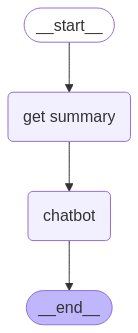

In [34]:
display(Image(graph_chatbot.get_graph().draw_mermaid_png()))

In [29]:
config = {'configurable': {'thread_id': "batman_chatbot"}}

In [35]:
user_input = input()
test = graph_chatbot.invoke({"prompt": user_input, "messages": [("human", user_input)]}, config=config)

In [36]:
test['output']

"As of the information available up to October 2023, I don't have access to real-time visa status updates. However, for your trip to Berlin, you will need a Schengen visa. Since your travel request (TR001) is already approved, it's likely that the visa process is underway or completed. I recommend checking with your HR or travel department to confirm your visa status."